In [5]:
import matplotlib.pyplot as plt
import numpy as np
# NOTICE THIS CHANGE. WE USUALLY USE  inline
%matplotlib notebook   

Yet another version of neural networks.  Please download and untar [nn3.tar.gz](http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn3.tar.gz)

In [6]:
import neuralnetworksbylayer as nn

In [7]:
class Canvas(object):

    def __init__(self, nnet, X, T):
        self.fig = plt.figure(2,(8,8))
        self.fig.clf()
        self.likelihoodAxis = self.fig.add_subplot(221)
        self.proj2dAxis = self.fig.add_subplot(222)
        self.proj2dAxis.set_xlim(-1,1)
        self.proj2dAxis.set_ylim(-1,1)
        self.drawAxis = self.fig.add_subplot(223)
        self.probAxis = self.fig.add_subplot(224)
        self.pressed = False
        self.nUpdates = 0

        self.fig.canvas.mpl_connect('button_press_event', self.onPress)
        self.fig.canvas.mpl_connect('button_release_event', self.onRelease)
        self.fig.canvas.mpl_connect('motion_notify_event',self.updateDrawing)

        # likelihood trace
        self.likelihoodAxis.plot(nnet.getErrorTrace())

        # 2d projections
        digit,prob,Z = nnet.use(X,allOutputs=True)
        neck = Z[int(len(Z)/2)]
        drawEvery = 500
        for i in range(0,T.shape[0],drawEvery):
            self.proj2dAxis.annotate(T[i,0],neck[i,:],
                                    horizontalalignment='center',
                                    verticalalignment='center') #,color=t)
        self.drawing2d = self.proj2dAxis.scatter(0,0,c='red',marker='o',s=200)
        self.proj2dAxis.set_xlim(-1.1,1.1)
        self.proj2dAxis.set_ylim(-1.1,1.1)
        
        # Drawing
        self.drawing = np.zeros((28,28))
        self.image = self.drawAxis.imshow(-self.drawing, interpolation='nearest',cmap='gray')
        self.drawAxis.set_xlim((0,27))
        self.drawAxis.set_ylim((27,0))
        # self.drawAxis.set_title('Left button draws, right erases one, middle erases all.')
        # self.drawAxis.axis('off')

        # Probabilities
        self.bars = self.probAxis.bar(np.arange(10)-0.5, [0.1]*10)
        self.probAxis.set_xticks(range(10))
        self.probAxis.axis('auto')
        self.probAxis.set_ylim(0,1)
        self.bigDigit = self.probAxis.text(5,0.5,'?',fontsize=100,
                                           color='red',alpha=0.8,
                                           horizontalalignment='center',
                                           verticalalignment='center')

        plt.draw()
        
    def onPress(self,event):
        self.pressed = True

    def onRelease(self,event):
        self.pressed = False
        if event.button == 2:
            self.drawing[:,:] = 0
            self.image.set_data(-1*self.drawing)
            self.image.autoscale()
        plt.draw()
            
    def updateDrawing(self,event):
        # If the mouse pointer is not on the canvas, ignore buttons
        if not self.pressed or not event.inaxes:
            return

        self.nUpdates += 1
        x = int(0.5+event.xdata)
        y = int(0.5+event.ydata)
        d = 1
        xa = max(0,x-d)
        xb = min(27,x+d)
        ya = max(0,y-d)
        yb = min(27,y+d)
                   
        if event.button == 1:
            # current = self.drawing[ya:yb+1, xa:xb+1]
            # self.drawing[ya:yb+1, xa:xb+1] = \
            #         np.maximum( current,np.ones((2*d+1,2*d+1))*0.8)
            self.drawing[ya:yb+1,xa:xb+1] = 1
        elif event.button == 3:
            self.drawing[ya:yb+1, xa:xb+1] = 0

        # Update digit
        self.image.set_data(-1*self.drawing)
        self.image.autoscale()

        # Update probabilities
        digit,probs,self.Z = nnet.use(self.drawing.reshape((1,-1)),allOutputs=True)
        for patch,prob in zip(self.bars.patches,probs[0,:]):
            patch.set_height(prob)
        sd = str(digit[0,0])
        self.bigDigit.set_text(sd)

        # 2d projection of drawing
        if self.nUpdates % 10 == 0:
            neck = self.Z[int(len(self.Z)/2)]
            self.drawing2d.set_offsets(neck)

        plt.draw()


In [12]:
if True: #input('train (y/n) ') == 'y':
    data = np.load('mnist.npz')
    X = data['X']
    T = data['T'].reshape((-1,1))
    n = 2000
    X = X[:n,:]; T = T[:n,:]

    hiddens = [50,2,50]
    nnet = nn.NeuralNetworkClassifier([X.shape[1]] + hiddens + [10])
    nnet.train(X,T,nIterations=100,verbose=True)

SCG: Iteration 10 ObjectiveF=0.81886 Scale=8.192e-03 Time=0.00313 s/iter
SCG: Iteration 20 ObjectiveF=0.87056 Scale=1.280e-04 Time=0.00270 s/iter
SCG: Iteration 30 ObjectiveF=0.89904 Scale=5.000e-07 Time=0.00283 s/iter
SCG: Iteration 40 ObjectiveF=0.92144 Scale=9.766e-10 Time=0.00275 s/iter
SCG: Iteration 50 ObjectiveF=0.94729 Scale=9.537e-13 Time=0.00271 s/iter
SCG: Iteration 60 ObjectiveF=0.95957 Scale=1.000e-15 Time=0.00268 s/iter
SCG: Iteration 70 ObjectiveF=0.96936 Scale=1.000e-15 Time=0.00266 s/iter
SCG: Iteration 80 ObjectiveF=0.97900 Scale=1.000e-15 Time=0.00272 s/iter
SCG: Iteration 90 ObjectiveF=0.98676 Scale=1.000e-15 Time=0.00267 s/iter
SCG: Iteration 100 ObjectiveF=0.99156 Scale=1.000e-15 Time=0.00277 s/iter


<IPython.core.display.Javascript object>


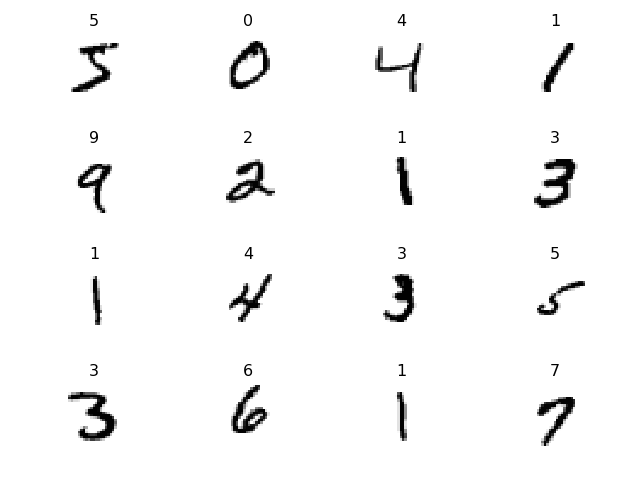

In [10]:
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(-X[i,:].reshape((28,28)),cmap='gray',interpolation='nearest')
    plt.axis('off')
    plt.title(T[i][0])
plt.tight_layout()

<IPython.core.display.Javascript object>


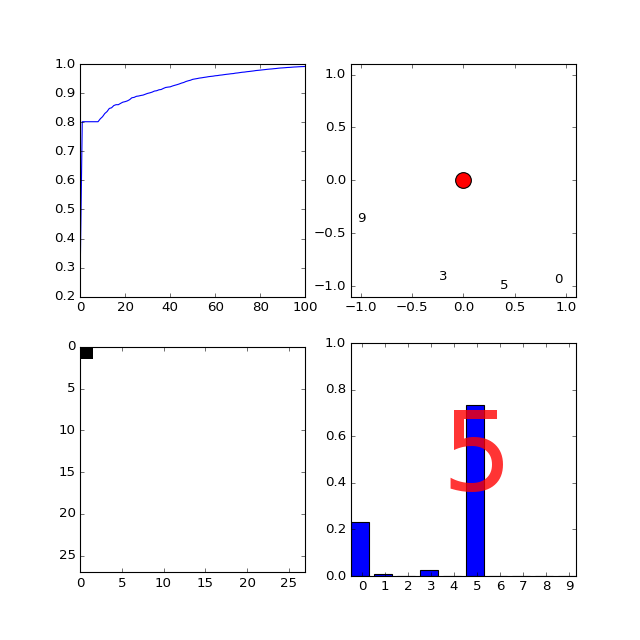

In [14]:
canvas = Canvas(nnet, X, T)

In [9]:
np.sum(nnet.use(X) == T) / len(T)

0.90317999999999998

In [10]:
np.sum(nnet.use(X) != T), len(T)

(4841, 50000)